In [206]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq

import matlab.engine
from datetime import datetime
import os

# Data pre-processing

In [193]:
raw_dat = pd.read_csv('UnderlyingOptionsIntervals_1800sec_2021-04-26.csv')

In [194]:
symbols = raw_dat['underlying_symbol'].unique()


In [195]:
expirations = raw_dat['expiration'].unique()
print(expirations)

for expiration in expirations:
    df_expiration = raw_dat[(raw_dat['expiration'] == expiration) 
                            & (raw_dat['underlying_symbol'] == "^VIX")
                            & (raw_dat['trade_volume'] != 0)]
    df_expiration.to_csv(f'data/vix_options_{expiration}.csv', index=False)

with open('expirations.txt', 'w') as f:
    for expiration in expirations:
        f.write(f"{expiration}\n")

['2021-06-18' '2023-01-20' '2021-08-20' '2021-11-19' '2022-01-21'
 '2021-05-21' '2021-04-28' '2021-05-19' '2021-08-18' '2021-05-05'
 '2021-06-16' '2021-05-26' '2021-10-20' '2021-12-22' '2021-11-17'
 '2021-09-15' '2021-05-12' '2021-07-21']


In [196]:
expiration_date = "2021-04-28"
options_dat = pd.read_csv(rf"data\vix_options_{expiration_date}.csv").sort_values('quote_datetime')
print(options_dat.tail())


   underlying_symbol       quote_datetime  root  expiration  strike  \
79              ^VIX  2021-04-26 16:15:00  VIXW  2021-04-28    19.0   
36              ^VIX  2021-04-26 16:15:00  VIXW  2021-04-28    17.0   
92              ^VIX  2021-04-26 16:15:00  VIXW  2021-04-28    20.0   
49              ^VIX  2021-04-26 16:15:00  VIXW  2021-04-28    18.0   
23              ^VIX  2021-04-26 16:15:00  VIXW  2021-04-28    17.0   

   option_type  open  high   low  close  trade_volume  bid_size   bid  \
79           P  1.10  1.10  1.10   1.10            11         7  1.02   
36           P  0.12  0.12  0.12   0.12           134       197  0.07   
92           C  0.17  0.17  0.17   0.17            10         7  0.15   
49           C  0.60  0.72  0.60   0.72            31         7  0.56   
23           C  1.25  1.25  1.20   1.20             2         1  1.20   

    ask_size   ask  underlying_bid  underlying_ask  
79        50  1.21           17.64           17.64  
36       566  0.12          

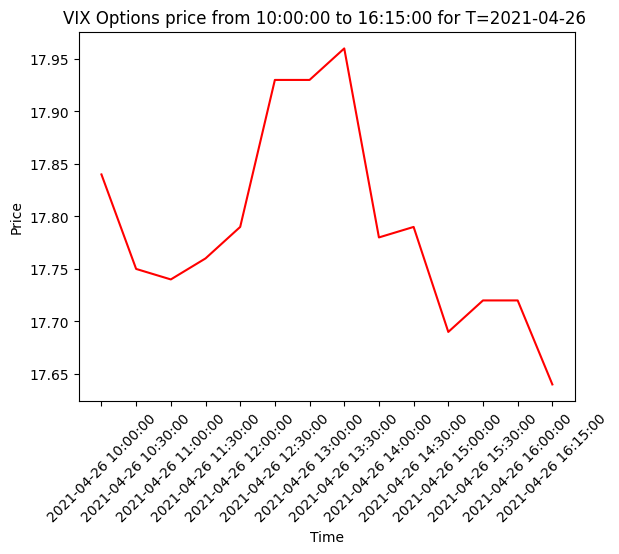

In [205]:
plt.plot(options_dat['quote_datetime'], options_dat['underlying_ask'], '-r')
plt.title(f'VIX Options price from {options_dat["quote_datetime"].iloc[0][-8:]} to {options_dat["quote_datetime"].iloc[-1][-8:]} for T={options_dat["quote_datetime"].iloc[-1][:11]}')
plt.xlabel('Time')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.show()

# Implied Volatility

before we can find the implied volatility, we need to a working price model to calibrate our own.
Let's use Black-Scholes.

In [198]:

def bsprice(S,K,r,T,sigma,option_type):
    d1 = (np.log(S/K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'C':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'P':
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    


In [199]:
eng = matlab.engine.start_matlab()
eng.cd(os.getcwd())

'C:\\Users\\dbjac\\Desktop\\MATLAB\\OptnSfc'

In [200]:
# recursively calling and quitting engine is not efficient
# but I have kept it in the function to easily recall the function later
def newton_raphson_impvol_MATLAB(S0, K, r, T, theo, sigma_hat, max_iter, tolerance,type):
    sigma_hat,iter = eng.newtonraphson(S0, K, r, T, theo, sigma_hat, max_iter, tolerance,type,nargout=2)
    return sigma_hat, iter

def bsimpvol_MATLAB(S0, K, r, T, price, type):
    sigma_hat = eng.jaeckel(S0, K, r, T, price, type,nargout=1)
    return sigma_hat



In [201]:
r = 0.015370 # April 2021 US Fed I.R.
t0 = "2021-04-26"
T = "2022-04-26" # 1 year from t0
t_dates = expirations
tau_days = [( datetime.strptime(t, '%Y-%m-%d') - datetime.strptime(t0, '%Y-%m-%d')).days for t in t_dates]
tau = [t / 365 for t in tau_days]
print(t_dates)
print(tau_days)
print(tau)

['2021-06-18' '2023-01-20' '2021-08-20' '2021-11-19' '2022-01-21'
 '2021-05-21' '2021-04-28' '2021-05-19' '2021-08-18' '2021-05-05'
 '2021-06-16' '2021-05-26' '2021-10-20' '2021-12-22' '2021-11-17'
 '2021-09-15' '2021-05-12' '2021-07-21']
[53, 634, 116, 207, 270, 25, 2, 23, 114, 9, 51, 30, 177, 240, 205, 142, 16, 86]
[0.14520547945205478, 1.736986301369863, 0.3178082191780822, 0.5671232876712329, 0.7397260273972602, 0.0684931506849315, 0.005479452054794521, 0.06301369863013699, 0.31232876712328766, 0.024657534246575342, 0.13972602739726028, 0.0821917808219178, 0.4849315068493151, 0.6575342465753424, 0.5616438356164384, 0.38904109589041097, 0.043835616438356165, 0.2356164383561644]


In [202]:

max_iterations = 100
tolerance = 0.0001
index_count = 0
for expiry in expirations:
    options_dat = pd.read_csv(rf"data\vix_options_{expiry}.csv").sort_values('quote_datetime')
    tau_opt = tau[index_count]
    for option in options_dat.iterrows():
        option = option[1]
        option_type = option['option_type']
        S = option['underlying_bid']
        K = option['strike']
        option_type = option['option_type']
        theo = option['open']
        moneyness = np.log(S/K)
        #sigma_hat,_ = newton_raphson_impvol_MATLAB(S, K, r, T, theo, sigma_hat, max_iterations, tolerance, option_type)
        sigma_hat = bsimpvol_MATLAB(S, K, r, tau_opt, theo, option_type)
        options_dat.loc[option.name, 'moneyness'] = moneyness
        options_dat.loc[option.name, 'implied_vol'] = sigma_hat
        
    options_dat.to_csv(rf"implied\vix_options_{expiry}.csv", index=False)
    index_count += 1

In [203]:
eng.quit()